# Import library

In [87]:
import cv2
import os
from cv2 import imread
from cv2 import fillPoly
from shapely import wkt
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data pre-processing

We select **Hurricane Mathew** event

## Read image

In [12]:
image_folder = 'train/images'
bulding_folder = 'train/buildings'

pre_image_files = []
post_image_files = []
pre_building_files = []
post_building_files = []

for root, dirs, files in os.walk(image_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("pre" in file):
            pre_image_files.append(imread(os.path.join(root, file)))
        elif ("hurricane-matthew" in file) and ("post" in file):
            post_image_files.append(imread(os.path.join(root, file)))

for root, dirs, files in os.walk(image_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("pre" in file):
            pre_building_files.append(imread(os.path.join(root, file)))
        elif ("hurricane-matthew" in file) and ("post" in file):
            post_building_files.append(imread(os.path.join(root, file)))

In [13]:
print(len(pre_image_files))
print(len(post_image_files))

238
238


## Read polygon

In [78]:
import pandas as pd
import json

labels_folder = 'train/labels'
count = 0
for root, dirs, files in os.walk(labels_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("post" in file) and (count==0):
            test = json.load(open(os.path.join(root, file)))
            main_df = pd.json_normalize(test, record_path=['features', 'lng_lat'])
            main_df['image'] = file.split('.')[0]
            count += 1
        elif ("hurricane-matthew" in file) and ("post" in file):
            test = json.load(open(os.path.join(root, file)))
            df = pd.json_normalize(test, record_path=['features', 'lng_lat'])
            df['image'] = file.split('.')[0]
            main_df = pd.concat([main_df, df], ignore_index=True)

train/labels


In [77]:
main_df

,wkt,properties.feature_type,properties.subtype,properties.uid,image
0,POLYGON ((-73.73999821958201 18.19645168390706...,building,minor-damage,6dd06e25-353d-4ca2-8a93-bbdd44b10435,hurricane-matthew_00000000_post_disaster
1,POLYGON ((-73.74012695415038 18.19649906723468...,building,minor-damage,29ea07d6-33b5-4c85-9a80-20eea786ab2f,hurricane-matthew_00000000_post_disaster
2,"POLYGON ((-73.74014403688365 18.1965502302046,...",building,minor-damage,25e32d78-3761-443d-8afb-e4b1d575ad30,hurricane-matthew_00000000_post_disaster
3,POLYGON ((-73.74006042030388 18.19652266297088...,building,minor-damage,63591a27-a002-4c86-a02c-e5c4282339cc,hurricane-matthew_00000000_post_disaster
4,POLYGON ((-73.74005471031927 18.19658868660606...,building,minor-damage,5416393e-158e-4bee-9f93-b70df29eab02,hurricane-matthew_00000000_post_disaster
...,...,...,...,...,...
13934,POLYGON ((-74.09714968659425 18.27231201919512...,building,destroyed,ceb3124e-0183-42e8-a26b-38c7844184cf,hurricane-matthew_00000401_post_disaster
13935,POLYGON ((-74.09774801834411 18.27229347634119...,building,destroyed,e748416c-b2f2-4aaf-aefa-89c5ff6468bd,hurricane-matthew_00000401_post_disaster
13936,POLYGON ((-74.09658657078509 18.27343661200825...,building,destroyed,060bbf4b-6dc6-42e1-b325-e75f819ab1f0,hurricane-matthew_00000401_post_disaster
13937,"POLYGON ((-74.09638183743883 18.273897772937, ...",building,destroyed,3627d4d1-2bb5-4406-aec0-00f8a88c87c7,hurricane-matthew_00000401_post_disaster


In [85]:
output_path = 'train/mask_polygon'

damage_dict = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 255
}

for root, dirs, files in os.walk(labels_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("post" in file):
            polygons = json.load(open(os.path.join(root, file)))
            h = polygons["metadata"]["height"]
            w = polygons["metadata"]["width"]
            mask_img = np.zeros((h, w), np.uint8)
            for feature in polygons['features']['xy']:
                feature_poly = wkt.loads(feature['wkt'])
                coords = list(mapping(feature_poly)['coordinates'][0])
                fillPoly(mask_img, [np.array(coords, np.int32)], damage_dict[feature['properties']['subtype']])
            output_name = file.split('.')[0] + ".png"
            isExist = os.path.exists(output_path)
            if not isExist:
                os.makedirs(output_path)
            cv2.imwrite(os.path.join('train/mask_polygon', output_name), mask_img)

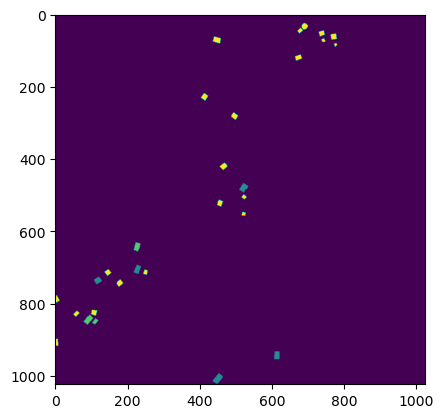

In [93]:
img = mpimg.imread('train/mask_polygon/hurricane-matthew_00000211_post_disaster.png')
imgplot = plt.imshow(img)
plt.show()